In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from helper import *

df, f_preprocessor, t_preprocessor, cols = create_data("./data/train.csv", type='train')


    

#X_sub, _, _ = create_data("./data/test.csv", type='sub', preprocessor=preprocessor)

2023-03-22 18:12:20,142 - INFO - Reading train data from ./data/train.csv
2023-03-22 18:12:20,146 - INFO - Start date: 2015-02-19
2023-03-22 18:12:20,147 - INFO - End date: 2021-12-31
2023-03-22 18:12:20,150 - INFO - missing days: 154
2023-03-22 18:12:20,150 - INFO - Featurizing time series data
2023-03-22 18:12:20,180 - INFO - Featurizing XML data
2023-03-22 18:12:25,383 - INFO - Imputing missing values...
2023-03-22 18:12:25,385 - INFO - Creating interactions...
2023-03-22 18:12:25,386 - INFO - Saving to Parquet file...


In [5]:
df.head()

,date,sleep_hours,day_of_week,day_of_year,month,month_sin,is_weekend,is_holiday,is_workday,is_daylight_savings,...,DistanceWalkingRunning_mn_st_hr_cos,DistanceWalkingRunning_mx_et_hr_sin,DistanceWalkingRunning_mx_et_hr_cos,DistanceWalkingRunning_mn_et_hr_sin,DistanceWalkingRunning_mn_et_hr_cos,DistanceWalkingRunning_hours_between,dow_median,distance_per_step,calorie_per_step,calorie_per_distance
0,2015-02-19,6.400000,3,50,2,0.866025,0,0,1,0,...,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0,6.716667,0.000492,0.711128,1446.789697
1,2015-02-20,7.583333,4,51,2,0.866025,0,0,1,0,...,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0,6.766667,0.000493,0.130429,264.791271
2,2015-02-21,6.350000,5,52,2,0.866025,1,0,0,0,...,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0,6.950000,0.000492,0.244304,496.350594
3,2015-02-22,6.500000,6,53,2,0.866025,1,0,0,0,...,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0,6.808333,0.000492,0.113823,231.576661
4,2015-02-23,8.916667,0,54,2,0.866025,0,0,1,0,...,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0,6.533333,0.000492,0.312377,635.530792


In [6]:

y_train = df['sleep_hours']
X_train = df[cols]

X_train.head()

,day_of_week,day_of_year,month,month_sin,is_weekend,is_holiday,is_workday,is_daylight_savings,BasalEnergyBurned,BasalEnergyBurned_mx_st_hr_sin,...,DistanceWalkingRunning_mn_st_hr_cos,DistanceWalkingRunning_mx_et_hr_sin,DistanceWalkingRunning_mx_et_hr_cos,DistanceWalkingRunning_mn_et_hr_sin,DistanceWalkingRunning_mn_et_hr_cos,DistanceWalkingRunning_hours_between,dow_median,distance_per_step,calorie_per_step,calorie_per_distance
0,3,50,2,0.866025,0,0,1,0,1898.0,0.0,...,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0,6.716667,0.000492,0.711128,1446.789697
1,4,51,2,0.866025,0,0,1,0,1898.0,0.0,...,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0,6.766667,0.000493,0.130429,264.791271
2,5,52,2,0.866025,1,0,0,0,1898.0,0.0,...,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0,6.950000,0.000492,0.244304,496.350594
3,6,53,2,0.866025,1,0,0,0,1898.0,0.0,...,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0,6.808333,0.000492,0.113823,231.576661
4,0,54,2,0.866025,0,0,1,0,1898.0,0.0,...,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0,6.533333,0.000492,0.312377,635.530792


In [7]:
# Create a simple XGBoost model
from xgboost import XGBRegressor


# param_grid = {
    # 'n_estimators': [100, 200, 300],
    # 'max_depth': [3, 6, 9],
    # 'learning_rate': [0.01, 0.1, 0.2, 0.3],
    # 'subsample': [0.75, 1],
    # 'colsample_bytree': [0.5, 0.75, 1],
    # 'gamma': [0, 0.1, 0.3],
    # 'disable_default_eval_metric': [1],
    # 'max_bin': [256, 512, 1024],
# }

temp_param_grid = {
    'n_estimators': [100],
    'max_depth': [3],
    'learning_rate': [0.01],
    'subsample': [0.75],
    'colsample_bytree': [0.5],
    'gamma': [0],
    'disable_default_eval_metric': [1],
    'max_bin': [256],
}

#xgb with GPU
xgb = XGBRegressor(tree_method='gpu_hist', gpu_id=0)

cv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=temp_param_grid,
    scoring = 'neg_root_mean_squared_error',
    cv=cv,
    verbose=2,
)

# Train the model
grid_search.fit(
    X_train,
    y_train,
    verbose=2,
)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bytree=0.5, disable_default_eval_metric=1, gamma=0, learning_rate=0.01, max_bin=256, max_depth=3, n_estimators=100, subsample=0.75; total time=   0.9s
[CV] END colsample_bytree=0.5, disable_default_eval_metric=1, gamma=0, learning_rate=0.01, max_bin=256, max_depth=3, n_estimators=100, subsample=0.75; total time=   0.2s
[CV] END colsample_bytree=0.5, disable_default_eval_metric=1, gamma=0, learning_rate=0.01, max_bin=256, max_depth=3, n_estimators=100, subsample=0.75; total time=   0.2s
[CV] END colsample_bytree=0.5, disable_default_eval_metric=1, gamma=0, learning_rate=0.01, max_bin=256, max_depth=3, n_estimators=100, subsample=0.75; total time=   0.2s
[CV] END colsample_bytree=0.5, disable_default_eval_metric=1, gamma=0, learning_rate=0.01, max_bin=256, max_depth=3, n_estimators=100, subsample=0.75; total time=   0.2s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=0,
                                    grow_policy=None, import...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.5],
                         'disable_default_eval_metric': [1], 'gamma': [0],
                         'learning_rate': [0.01], 'max_bin': [256],
                         'max_depth': [3], 'n_estimators': [100],
                         'subsample': [0.75]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [9]:
# Retrieve the best hyperparameters from the grid search
print("Best params: ",  grid_search.best_params_)
# Save best parameters to json file
import json
best_params = grid_search.best_params_
with open('best_params_xgb.json', 'w') as fp:
    json.dump(best_params, fp)

# Best score
print("Best score: ", grid_search.best_score_)

# Best estimator
print("Best estimator: ", grid_search.best_estimator_)


Best params:  {'colsample_bytree': 0.5, 'disable_default_eval_metric': 1, 'gamma': 0, 'learning_rate': 0.01, 'max_bin': 256, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.75}
Best score:  -2.4230480884744763
Best estimator:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, disable_default_eval_metric=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=256,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)


In [12]:
from sklearn.metrics import mean_squared_error

final_model = grid_search.best_estimator_

X_train_prep = f_preprocessor.fit_transform(X_train)
X_train_prep = pd.DataFrame(X_train_prep, columns=cols)


final_model.fit(X_train_prep, y_train)

y_pred = final_model.predict(X_train_prep)

mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

RMSE:  2.4789794584263816


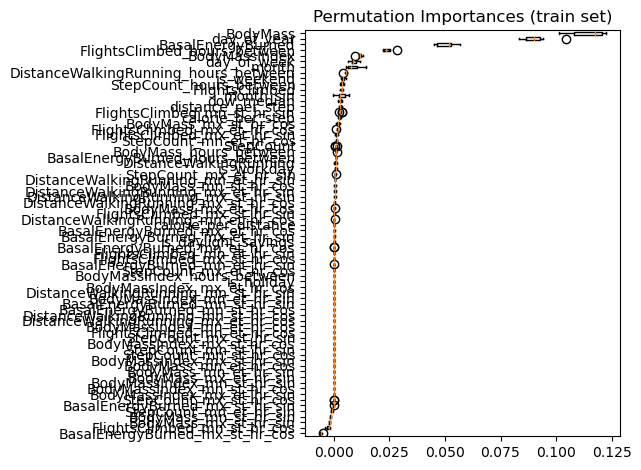

In [13]:
# Feature importance
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(final_model, X_train_prep, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train_prep.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [7]:
X_test, _, _, _ = create_data("./data/test.csv", type='test')
X_test.head()

2023-03-21 21:50:51,869 - INFO - Reading test data from ./data/test.csv
2023-03-21 21:50:51,873 - INFO - Featurizing time series data
2023-03-21 21:50:51,899 - INFO - Featurizing XML data
2023-03-21 21:50:56,987 - INFO - Imputing missing values...
2023-03-21 21:50:56,989 - INFO - Creating interactions...
2023-03-21 21:50:56,990 - INFO - Saving to Parquet file...


,date,sleep_hours,day_of_week,day_of_year,month,month_sin,is_weekend,is_holiday,is_workday,is_daylight_savings,...,DistanceWalkingRunning_mn_st_hr_cos,DistanceWalkingRunning_mx_et_hr_sin,DistanceWalkingRunning_mx_et_hr_cos,DistanceWalkingRunning_mn_et_hr_sin,DistanceWalkingRunning_mn_et_hr_cos,DistanceWalkingRunning_hours_between,dow_median,distance_per_step,calorie_per_step,calorie_per_distance
0,2022-01-01,1,5,1,1,0.5,1,0,0,0,...,1.0,-0.500000,0.866025,0.0,1.0,1.788333,1.0,0.000840,0.108729,129.487177
1,2022-01-02,1,6,2,1,0.5,1,0,0,0,...,1.0,0.000000,1.000000,0.0,1.0,0.296111,1.0,0.001058,0.078585,74.255554
2,2022-01-03,1,0,3,1,0.5,0,0,1,0,...,1.0,-0.866025,0.500000,0.0,1.0,4.187500,1.0,0.000905,0.105842,116.901203
3,2022-01-04,1,1,4,1,0.5,0,0,1,0,...,1.0,-0.258819,0.965926,0.0,1.0,0.962222,1.0,0.000894,0.119018,133.117587
4,2022-01-05,1,2,5,1,0.5,0,0,1,0,...,1.0,-0.258819,0.965926,0.0,1.0,0.682222,1.0,0.000982,0.086861,88.455068


In [8]:
X_test_prep = f_preprocessor.transform(X_test[cols])
y_sub = xgb.predict(X_test_prep)

print(y_sub)

[6.0360446 5.910492  6.885395  6.0591474 5.4594646 6.4272714 6.5072284
 6.2744207 4.0497003 4.1141953 4.6217923 7.681216  5.9396687 7.628961
 6.526358  4.3451223 6.4154506 6.683134  7.0844045 6.184241  7.411443
 6.524643  7.4282928 6.281891  6.7063923 5.4336734 6.1885552 6.0428696
 6.1785474 6.420884  7.9039474 7.044483  6.4276347 8.142161  6.734049
 5.5461197 6.4658027 8.200009  6.9662724 6.865883  7.757431  5.9102306
 5.9884706 6.5381007 6.6722636 7.2010264 4.430268  5.490394  5.4610224
 5.9904137 6.4504313 7.567182  7.4349465 7.8879914 6.2462153 7.430247
 6.3526573 6.983762  7.152419  6.9189215 6.152974  6.7940636 6.249092
 7.4925694 6.326573  6.3693123 7.581877  6.115166  5.8868484 7.955889
 5.8305993 6.9600644 6.744718  6.592478  6.1121316 6.8349233 6.6921463
 8.1709    7.1097527 6.311428  8.475187  5.3262997 6.8817883 6.396359
 6.1710334 6.25416   6.4555697 8.090836  6.0620885 6.226318  5.9527106
 7.318673  6.072893  7.2572513 7.2636776 6.208548  6.8072953 6.8641057
 6.7083697 6.

In [9]:
# sub = pd.read_csv('./data/sample_submission.csv')

# Make sure sorted by date
# sub = sub.sort_values(by='date')
# sub['sleep_hours'] = y_sub
# sub.to_csv('./submissions/submission_xgb.csv', index=False)

# sub.head()
# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_xgb.csv -m "Trying XGB model"

,date,sleep_hours
0,2022-01-01,6.036045
1,2022-01-02,5.910492
2,2022-01-03,6.885395
3,2022-01-04,6.059147
4,2022-01-05,5.459465
